<a href="https://colab.research.google.com/github/IndushreeReddy/olk-early-oscc-biomarker-detection/blob/main/Statistical_analysis_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and settings

In [17]:
#Import necessary libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
np.random.seed(42)

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

Load and Align QIIME2 feature table & metadata

In [18]:
# Load Feature Table (QIIME2 exported .tsv)

feature_table = pd.read_csv(
    "feature-table.tsv",
    sep="\t",
    skiprows=1,      # IMPORTANT: QIIME2 tables have an extra header row
    index_col=0
)

print("Feature table shape (ASVs x Samples):", feature_table.shape)

# transpose → ML format (Samples x ASVs)
X_asv = feature_table.T
print("Transposed feature table (Samples x ASVs):", X_asv.shape)


# Load Sample Metadata

metadata = pd.read_csv(
    "sample_metadata.tsv",
    sep="\t",
    comment="#",
    index_col="sample-id"
)

# remove QIIME type row if present
metadata = metadata[metadata.index != "#q2:types"]

# standardize labels
metadata["sample_type"] = metadata["sample_type"].astype(str).str.strip().str.lower()
metadata["Condition"] = metadata["sample_type"]

print(metadata["Condition"].value_counts())


# Align Samples in table and metadata

common_samples = X_asv.index.intersection(metadata.index)

X_asv = X_asv.loc[common_samples]
metadata = metadata.loc[common_samples]

print("Aligned feature table:", X_asv.shape)
print("Aligned metadata:", metadata.shape)

Feature table shape (ASVs x Samples): (12575, 72)
Transposed feature table (Samples x ASVs): (72, 12575)
Condition
pre-cancerous    40
healthy          32
Name: count, dtype: int64
Aligned feature table: (72, 12575)
Aligned metadata: (72, 11)


Load taxonomy and make ASV to Genus mapping

In [29]:
# Load Taxonomy

taxonomy = pd.read_csv("taxonomy.tsv", sep="\t")

taxonomy["Genus"] = taxonomy["Taxon"].str.extract(r"g__([^;]+)")
taxonomy["Genus"] = taxonomy["Genus"].fillna("Unassigned")

asv_to_genus = taxonomy.set_index("Feature ID")["Genus"].to_dict()

print("Total ASVs in taxonomy:", len(asv_to_genus))

# Collapse ASVs to Genus (sum across ASVs)

X_genus = X_asv.groupby(pd.Series(asv_to_genus), axis=1).sum()

# relative abundance (recommended for visualization)
X_genus_rel = X_genus.div(X_genus.sum(axis=1), axis=0)

print("Genus table shape:", X_genus.shape)

Total ASVs in taxonomy: 12575
Genus table shape: (72, 283)


/tmp/ipython-input-802298067.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_genus = X_asv.groupby(pd.Series(asv_to_genus), axis=1).sum()


Exploratory Plots

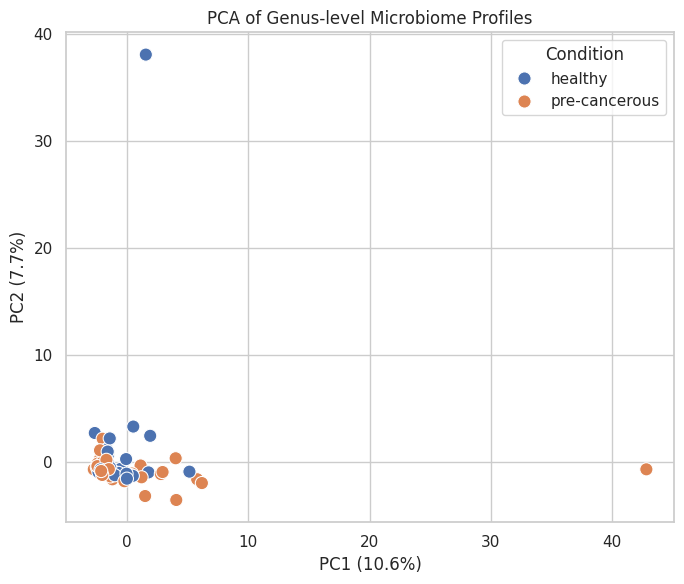

In [21]:
# PCA on genus-level relative abundance

X_scaled = StandardScaler().fit_transform(X_genus_rel)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=X_genus_rel.index)
pca_df["Condition"] = metadata["Condition"]

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Condition", s=90)
plt.title("PCA of Genus-level Microbiome Profiles")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/PCA_genus.png", dpi=300)
plt.show()

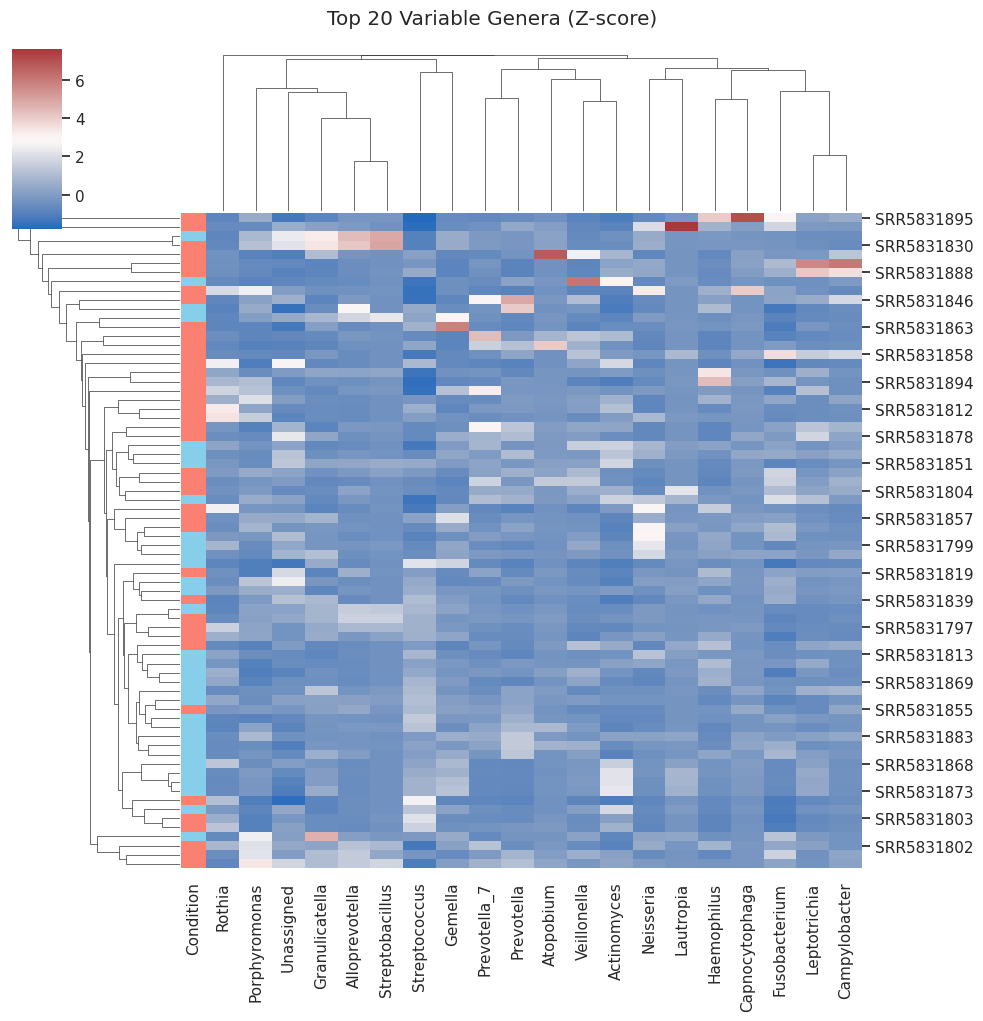

In [22]:
# Heatmap of top 20 variable genera

top_genera = X_genus_rel.var().sort_values(ascending=False).head(20).index
heatmap_data = X_genus_rel[top_genera]

# Z-score each genus

heatmap_z = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

row_colors = metadata["Condition"].map({
    "healthy": "skyblue",
    "pre-cancerous": "salmon"
})

g = sns.clustermap(
    heatmap_z,
    cmap="vlag",
    row_colors=row_colors,
    figsize=(10, 10)
)

plt.suptitle("Top 20 Variable Genera (Z-score)", y=1.02)
plt.savefig(f"{FIG_DIR}/Heatmap_top20_genera.png", dpi=300, bbox_inches="tight")
plt.show()

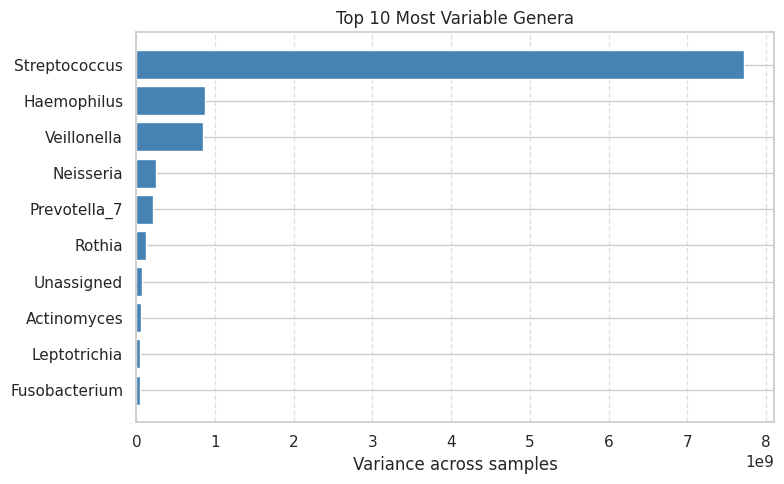

In [32]:
# Top 10 most variable genera

abundance_genus = X_genus.copy()

# Compute variance across samples
genus_variance = abundance_genus.var(axis=0)

# Select top 10 most variable genera
top10 = genus_variance.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top10.index, top10.values, color="steelblue")

plt.xlabel("Variance across samples")
plt.title("Top 10 Most Variable Genera")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

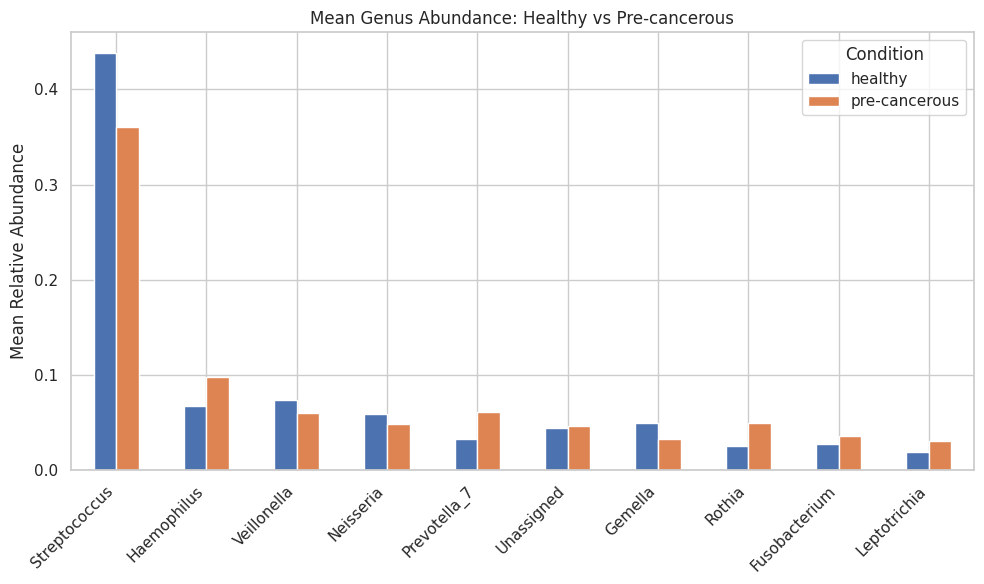

In [33]:
#Mean genus abundance among the samples

# Convert to relative abundance
rel_abundance = abundance_genus.div(abundance_genus.sum(axis=1), axis=0)

# Compute group means
group_means = rel_abundance.join(metadata["Condition"]) \
    .groupby("Condition").mean().T

# Select top 10 genera by overall abundance
top10 = group_means.mean(axis=1).sort_values(ascending=False).head(10)

# Plot
group_means.loc[top10.index].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Mean Relative Abundance")
plt.title("Mean Genus Abundance: Healthy vs Pre-cancerous")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Machine Learning

In [23]:

# ML Labels (y)

y = metadata["Condition"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_asv, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)


# SMOTE (handles class imbalance)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Class mapping: {'healthy': 0, 'pre-cancerous': 1}


In [25]:
def plot_confusion(y_true, y_pred, classes, title, save_path):
    """
    Plot and save a confusion matrix heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

=== Logistic Regression Report ===
               precision    recall  f1-score   support

      healthy       0.56      0.71      0.62         7
pre-cancerous       0.67      0.50      0.57         8

     accuracy                           0.60        15
    macro avg       0.61      0.61      0.60        15
 weighted avg       0.61      0.60      0.60        15



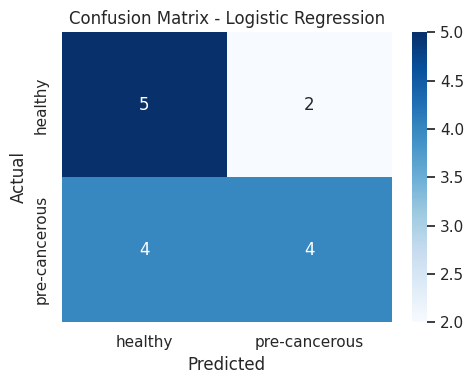

In [26]:

# Logistic Regression Model

lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

print("=== Logistic Regression Report ===")
print(classification_report(y_test, lr_preds, target_names=le.classes_))

plot_confusion(
    y_test, lr_preds, le.classes_,
    title="Confusion Matrix - Logistic Regression",
    save_path=f"{FIG_DIR}/CM_logistic_regression.png"
)

=== Random Forest Report ===
               precision    recall  f1-score   support

      healthy       0.80      0.57      0.67         7
pre-cancerous       0.70      0.88      0.78         8

     accuracy                           0.73        15
    macro avg       0.75      0.72      0.72        15
 weighted avg       0.75      0.73      0.73        15



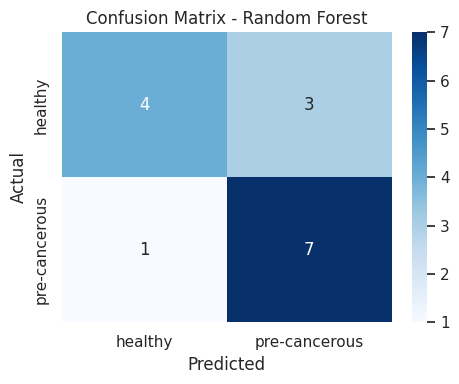

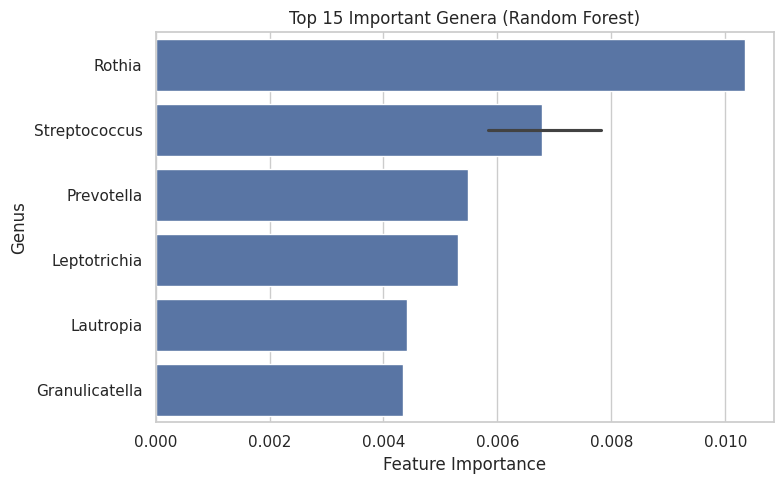

In [27]:

# Random Forest Model

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print("=== Random Forest Report ===")
print(classification_report(y_test, rf_preds, target_names=le.classes_))

plot_confusion(
    y_test, rf_preds, le.classes_,
    title="Confusion Matrix - Random Forest",
    save_path=f"{FIG_DIR}/CM_random_forest.png"
)


# Feature Importance (Top 15)

importances = pd.Series(rf.feature_importances_, index=X_asv.columns)
top15_asv = importances.sort_values(ascending=False).head(15)

# Convert ASVs → Genus labels
top15_genus = top15_asv.rename(index=lambda x: asv_to_genus.get(x, "Unassigned"))

# remove unassigned labels (optional)
top15_genus = top15_genus[top15_genus.index != "Unassigned"]

plt.figure(figsize=(8, 5))
sns.barplot(x=top15_genus.values, y=top15_genus.index)
plt.title("Top 15 Important Genera (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Genus")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/RF_top15_feature_importance_genus.png", dpi=300)
plt.show()

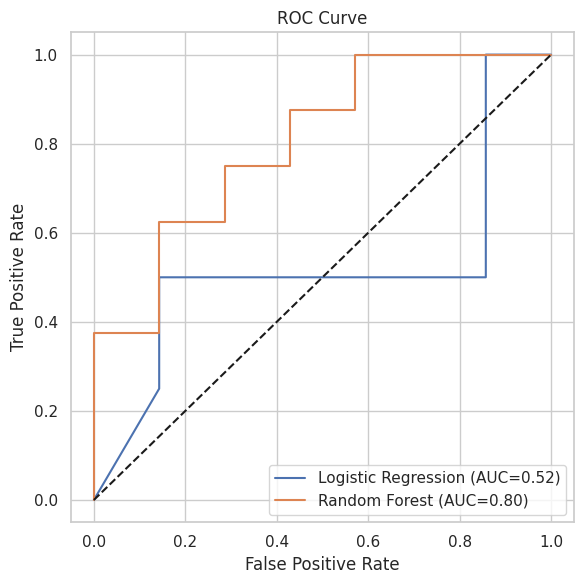

In [28]:
# ROC Curve
def plot_roc_curve(y_true, prob, label):
    fpr, tpr, _ = roc_curve(y_true, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

# probabilities
lr_prob = lr.predict_proba(X_test)[:, 1]
rf_prob = rf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6, 6))
plot_roc_curve(y_test, lr_prob, "Logistic Regression")
plot_roc_curve(y_test, rf_prob, "Random Forest")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/ROC_curve.png", dpi=300)
plt.show()